# **VGG16 Model**

In [1]:
import os
base_path="Dataset/train_img"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'train_label'])

In [2]:
rows= open(annotations).read().strip().split("\n")

data=[]
targets=[]
filenames=[]

In [3]:
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")
  (filename,startX,startY,endX,endY)=row

  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  startX = float(startX) / w
  startY = float(startY) / h 
  endX = float(endX) / w
  endY = float(endY) / h
  image=load_img(imagepaths,target_size=(224,224))
  image=img_to_array(image)

  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)


In [4]:
# Normalizing Data here also we face would face issues if we take input as integer
import numpy as np
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [5]:
# we should seperate data into train and split so import sklearn library 
from sklearn.model_selection import train_test_split

In [6]:
# split into testing and training
split=train_test_split(data,targets,filenames,test_size=0.10,random_state=42)

In [7]:
# lets split into steps
(train_images,test_images) = split[:2]
(train_targets,test_targets) = split[2:4]
(train_filenames,test_filenames) = split[4:]


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

In [9]:
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [10]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras.layers import Input,Flatten,Dense

In [12]:
# we use VGG16 as per our requirement not use whole 
vgg.trainable = False

flatten = vgg.output

flatten = Flatten()(flatten)

In [13]:
bboxhead = Dense(128,activation="relu")(flatten)
bboxhead = Dense(64,activation="relu")(bboxhead)
bboxhead = Dense(32,activation="relu")(bboxhead)
bboxhead = Dense(4,activation="relu")(bboxhead)

In [14]:
# lets import Model
from tensorflow.keras.models import Model
model = Model(inputs = vgg.input,outputs = bboxhead)

In [15]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [16]:
# Lets fit our model 
# Optimization 
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-4)

In [17]:
model.compile(loss='mse',optimizer=opt)

In [18]:
history = model.fit(train_images,train_targets,validation_data=(test_images,test_targets),batch_size=32,epochs=50,verbose=1)

Epoch 1/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0342 - val_loss: 0.0186
Epoch 2/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 3/50
23/23 [==============================] - 4s 153ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 5/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 6/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/50
23/23 [==============================] - 3s 148ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/50
23/23 [==============================] - 3s 147ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/50
23/23 [==============================] - 3s 146ms/step - loss: 7.5519e-04 - val_loss: 0.0020
Epoch 10/50
23/23 [==============================] - 3s 142ms/step - loss: 6.2409e-04 - val_loss

In [18]:
# lets save model 
model.save('detect_dog_faces.h5')

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model=load_model('/result/detect_dog_faces.h5')

In [21]:
imagepath='E:/Dog Face Detection using DL/Dataset/val_img'

In [22]:
image = load_img(imagepath,
                 target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

In [23]:
preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

In [24]:
import imutils

In [25]:
image=cv2.imread(imagepaths)
image=imutils.resize(image,width=600)

In [26]:
(h,w)=image.shape[:2]

In [27]:
startX=int(startX * w)
startY=int(startY * h)

endX=int(endX * w)
endY=int(endY * h)

In [28]:
cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_10074.jpg
[INFO] dog: 93.61%


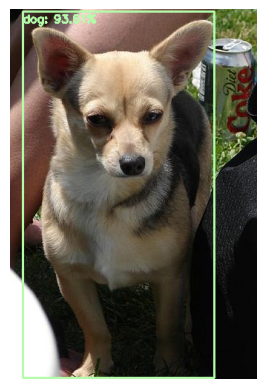

[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_10131.jpg
[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_10621.jpg
[INFO] dog: 96.83%


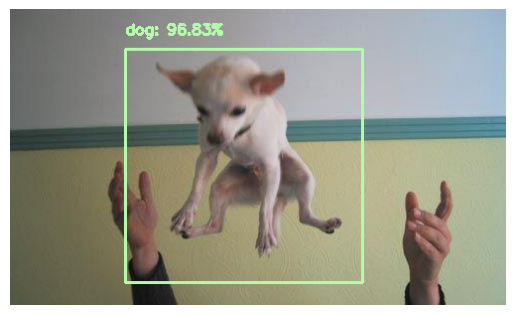

[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_1073.jpg
[INFO] dog: 99.84%


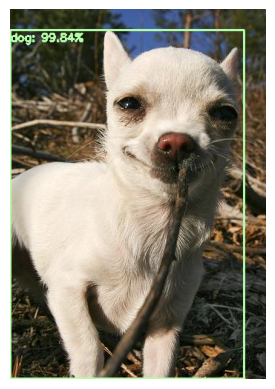

[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_10976.jpg
[INFO] dog: 99.98%


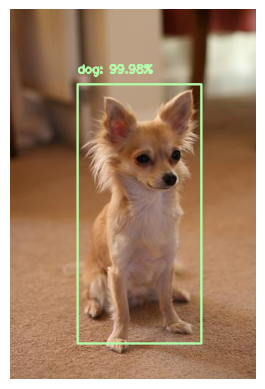

[INFO] Computing object detections for E:/Dog Face Detection using DL/Dataset/train_img\n02085620_11140.jpg
[INFO] dog: 98.99%


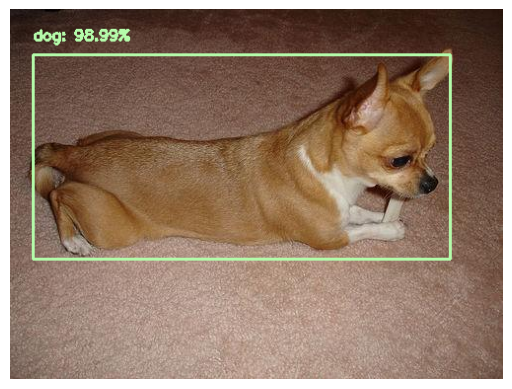

In [29]:
count = 5
for dogs in dogs_detected:
    count-=1
    if count <= 0:
        break
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    


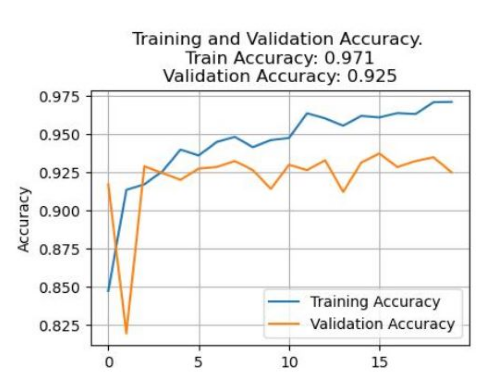

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot training and validation loss


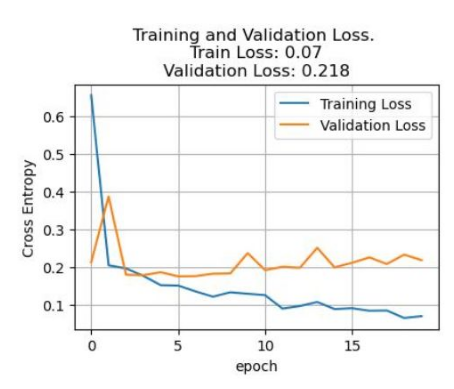

In [31]:
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Crosss Entropy')
plt.legend()

plt.show()